# 実習7
### RNNを用いてSin波の続きを予測

### 参考
詳解-ディープラーニング-TensorFlow・Kerasによる時系列データ処理(https://www.amazon.co.jp/詳解-ディープラーニング-TensorFlow・Kerasによる時系列データ処理-巣籠-悠輔-ebook/dp/B072JC21DH/ref=dp_kinw_strp_1)
https://www.infiniteloop.co.jp/blog/2018/02/learning-keras-07/

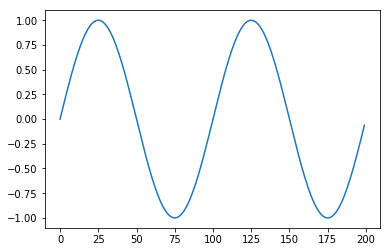

In [0]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
 
def sin2p(x, t=100):
    return np.sin(2.0 * np.pi * x / t) # sin(2πx/t), t = 周期
 
def sindata(t=100, cycle=2):
    x = np.arange(0, cycle*t) # 0 から cycle * t 未満の数
    return sin2p(x)
 
plt.plot(sindata(100, 2)) # 1周期100個データ、2周期分
plt.show()

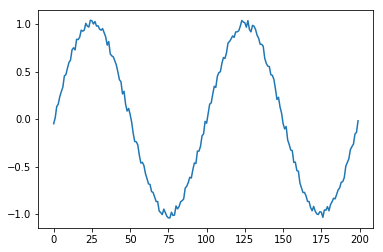

In [0]:
# Sin波にランダムノイズを加える
def noisy(Y, noise_range=(-0.05, 0.05)):
    noise = np.random.uniform(noise_range[0], noise_range[1], size=Y.shape) #random.uniform(low, high): low以上high未満の一様乱数を1個生成
    return Y + noise
 
plt.plot(noisy(sindata(100, 2), (-0.05, 0.05) ))
plt.show()

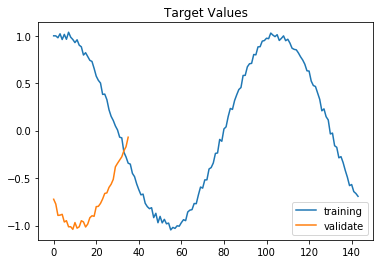

In [0]:
# training dataとvalidaiton dataの準備

from sklearn.model_selection import train_test_split
 
np.random.seed(0)
 
rawdata = noisy(sindata(100,2), (-0.05, 0.05)) # 2周期分のノイズあり sin 波データを生成
#rawdata = sindata(100,2) # 2周期分のノイズ無し sin 波データを生成
inputlen = 20 # 1入力データはデータ 20 個としました
 
input=[]
target=[]
for i in range(0, len(rawdata) - inputlen):  # range(0, 180)   0 .. 179 の 180回実行
    input.append( rawdata[i:i+inputlen] )  # [i:i+20] のスライスで i から i+19 の20個を入力データに追加
    target.append( rawdata[i+inputlen] )  # [i+20] がその直前までのデータ群 [i:i+20] の正解値となるのでターゲットに追加

    
# numpyの3次元配列に変換
X = np.array(input).reshape(len(input), inputlen, 1) # 入力データ (180, 20, 1)
Y = np.array(target).reshape(len(input), 1) # ターゲット (180, 1)
 
# トレーニングと評価用にデータを 8:2 に分割します。デフォルトがシャッフルなのでしないようにFlaseに
train_x, val_x, train_y, val_y = train_test_split(X, Y, test_size=int(len(X) * 0.2), shuffle=False)
 
# 訓練データの正解値 y と評価用データの正解値 val_y のグラフ
plt.plot(train_y, label="training")
plt.plot(val_y, label="validate")
plt.title('Target Values')
plt.legend()
plt.show()


In [0]:
# SimpleRNNのモデルを作成する

from keras.layers.recurrent import SimpleRNN
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Dense, Activation
 
n_in = 1
n_hidden = 20
n_out = 1
epochs = 20
batch_size = 16

model=Sequential()
model.add(SimpleRNN(n_hidden, input_shape=(inputlen, n_in)))
model.add(Dense(n_out))
model.add(Activation('linear'))
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_4 (SimpleRNN)     (None, 20)                440       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 21        
_________________________________________________________________
activation_4 (Activation)    (None, 1)                 0         
Total params: 461
Trainable params: 461
Non-trainable params: 0
_________________________________________________________________


In [0]:
# compileします
model.compile(loss='mean_squared_error', 
              optimizer=Adam(lr=0.01))

In [0]:
# 学習

# early stopping (val_lossが小さくなったら学習を打ち切る設定)
from keras.callbacks import EarlyStopping
EarlyStopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='auto')
"""
arguments: description
monitor: 監視値指定．例えば，monitor='val_loss'
patience: ループの最低数(monitorの値が改善しなくなってから何epochで止めるか)
verbose: 保存時に標準出力にコメントを出すか指定．{0, 1}
mode: 上限，下限どちらの側に収束した場合に収束判定を出すかの規定．{auto, min, max}
"""

model.fit(train_x, train_y, 
          batch_size=batch_size, 
          epochs=epochs, 
          validation_data=(val_x, val_y),
          callbacks=[EarlyStopping])

Train on 144 samples, validate on 36 samples
Epoch 1/20
144/144 [==============================] - 1s 5ms/step - loss: 0.0019 - val_loss: 0.0017
Epoch 2/20
144/144 [==============================] - 0s 250us/step - loss: 0.0014 - val_loss: 0.0017
Epoch 3/20
144/144 [==============================] - 0s 266us/step - loss: 0.0013 - val_loss: 0.0018
Epoch 4/20
144/144 [==============================] - 0s 251us/step - loss: 0.0013 - val_loss: 0.0016
Epoch 5/20
144/144 [==============================] - 0s 263us/step - loss: 0.0012 - val_loss: 0.0020
Epoch 6/20
144/144 [==============================] - 0s 254us/step - loss: 0.0014 - val_loss: 0.0016
Epoch 7/20
144/144 [==============================] - 0s 256us/step - loss: 0.0013 - val_loss: 0.0016
Epoch 00007: early stopping


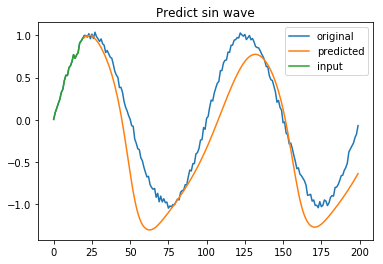

In [0]:
# 本来は評価データを使うべきですが、グラフの見栄え的に元データの左端を与えて
# 右側を予測させたかったので訓練データ x の先頭を与える
 
in_ = train_x[:1] # x の先頭 (1,20,1) 配列
 
# グラフで予測データ（オレンジ）が入力データ（緑）の後に来るように
# 予測データの先頭に None を20個入れる
predicted = [None for _ in range(inputlen)] 
 
for _ in range(len(rawdata) - inputlen):
    out_ = model.predict(in_) # 予測した値 out_ は (1,1) 配列
     
    # in_ を (20,1) 配列に変換し、先頭1個をスライスして削り、末尾に out_ を足す。
    # 最後に再度 (1,20,1) 配列に変換して、全体を次の in_ にする
    in_ = np.concatenate( (in_.reshape(inputlen, n_in)[1:], out_), axis=0 ).reshape(1, inputlen, n_in)
     
    # out_ は (1,1) 配列なので任意の長さの一次元配列に変換する reshape(-1) をかけてから予測データに追加
    predicted.append(out_.reshape(-1))

plt.title('Predict sin wave')   
plt.plot(rawdata, label="original")
plt.plot(predicted, label="predicted")
plt.plot(train_x[0], label="input")
plt.legend()
plt.show()
